## ECE 579M ST: Machine Learning in Cybersecurity
### Project Two: Adversarial Image Crafting
#### Fast Gradient Sign Method (FGSM) Attack

---
## Step 0: Import required packages

In [1]:
## LIST OF ALL IMPORTS
import sys
import os
import csv
import math
import random
import time
import os.path as path
import cv2
import glob
import numpy as np
from numpy.random import randint, RandomState

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import keras
import tensorflow as tf
from keras import backend as K
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input,decode_predictions

from foolbox.models import KerasModel
from foolbox.attacks import FGSM
from foolbox.criteria import Misclassification, TopKMisclassification, OriginalClassProbability
from foolbox.criteria import TargetClass, TargetClassProbability

from utils import expand_dims, kpredictions, load_image, normalize01

# Visualizations will be shown in the notebook.
%matplotlib inline 

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


---
## Step 1: Load Pretrained Model

In [2]:
# ImageNet used to train ResNet-50

model=ResNet50(include_top=True,
               weights='imagenet',
               input_tensor=None,
               input_shape=None,
               pooling=None,
               classes=1000)

# model.summary()

----

## Step 2: Crafting Adversarial Images

The goal is to build rogue/adversarial images that fool ML classifiers (ResNet50) with high confidence using Foolbox package.

1. foolbox.models: Wrap models with different frameworks (Tensorflow, Keras, Pytorch etc).
2. foolbox.criteria: Creates adversarial images targeted to:
                            1. Misclassification: Predicted class is not the original class.
                            2. Top-K Misclassification: Predicted k-classes doesn't contain the original class.
                            3. Original Class Probability: Probability of original class is below a threshold.
                            4. Target Class: Predicted class is the given target class.
                            5. Target Class Probability: Predicted class is the given target above a threshold. 
3. foolbox.distances: Distance metric between images (mean-squared error, or mean-absolute error).
4. foolbox.attacks: Types of adversarial attacks that can be run.
                            1. Gradient-based
                            2. Score-based 
                            3. Decision-based 

In [3]:
num_images=10 # Number of images for each attack type

---
### 2.4: FGSM

In [4]:
image_path='sample_images/*.jpg'
glob_paths=glob.glob(image_path)

Attacking sheepdog image:


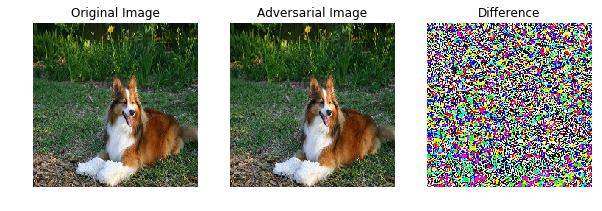

Time taken 6.0 s
Top Three original image predictions:
[('collie', 0.8471542), ('Shetland_sheepdog', 0.14195466), ('Pembroke', 0.009464289)]
Top Three adversarial image predictions:
[('Pembroke', 0.587028), ('Shetland_sheepdog', 0.37832546), ('Cardigan', 0.028877892)]


Attacking sweet_potato image:


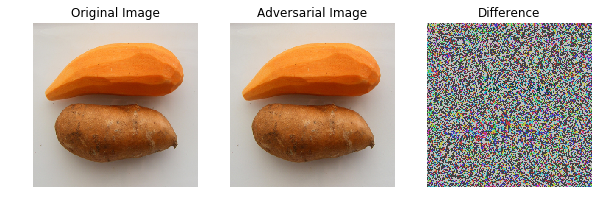

Time taken 5.74 s
Top Three original image predictions:
[('butternut_squash', 0.5346846), ('French_loaf', 0.16036452), ('bolete', 0.06349691)]
Top Three adversarial image predictions:
[('French_loaf', 0.7846476), ('hotdog', 0.063507594), ('bagel', 0.03153243)]


Attacking monkey_dog image:


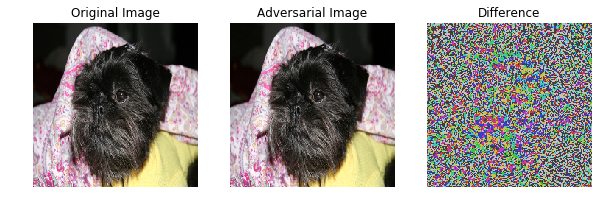

Time taken 6.51 s
Top Three original image predictions:
[('affenpinscher', 0.9503112), ('Brabancon_griffon', 0.037185825), ('miniature_schnauzer', 0.0037101463)]
Top Three adversarial image predictions:
[('Brabancon_griffon', 0.29380053), ('Kerry_blue_terrier', 0.213847), ('giant_schnauzer', 0.12022987)]


Attacking blimp image:


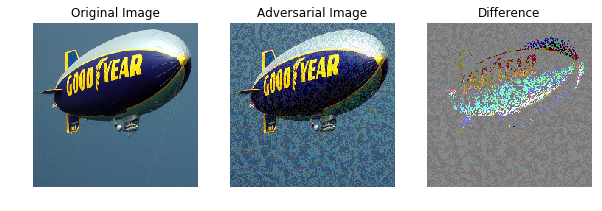

Time taken 8.48 s
Top Three original image predictions:
[('airship', 0.999995), ('airliner', 3.715651e-06), ('rugby_ball', 4.723452e-07)]
Top Three adversarial image predictions:
[('matchstick', 0.06504414), ('lighter', 0.062194012), ('packet', 0.043713614)]


Attacking domestic_cat image:


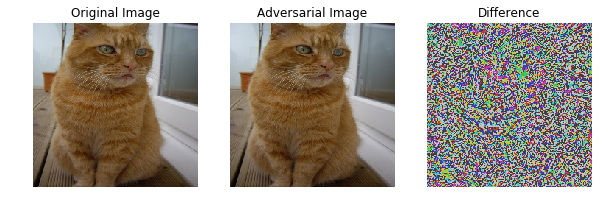

Time taken 6.15 s
Top Three original image predictions:
[('tabby', 0.42721045), ('tiger_cat', 0.31901157), ('Egyptian_cat', 0.047653202)]
Top Three adversarial image predictions:
[('refrigerator', 0.2676486), ('tiger_cat', 0.23489462), ('hamper', 0.11370326)]


Attacking polar_bear image:


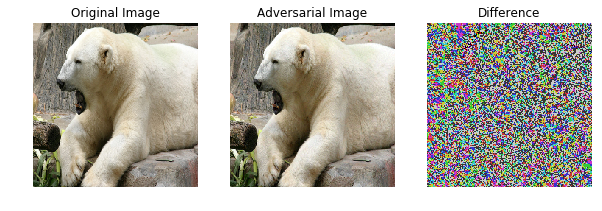

Time taken 7.28 s
Top Three original image predictions:
[('ice_bear', 0.99766016), ('brown_bear', 0.0011053854), ('gorilla', 0.00015318804)]
Top Three adversarial image predictions:
[('bull_mastiff', 0.09127036), ('Great_Pyrenees', 0.0599357), ('kuvasz', 0.057263933)]


Attacking mushroom image:


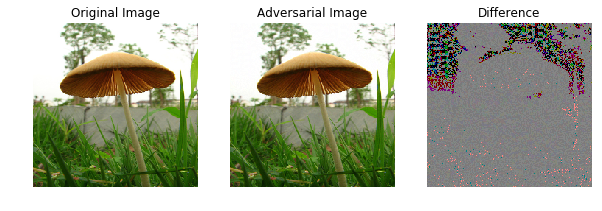

Time taken 6.65 s
Top Three original image predictions:
[('mushroom', 0.98873377), ('carousel', 0.004570984), ('agaric', 0.0039187996)]
Top Three adversarial image predictions:
[('carousel', 0.9805557), ('restaurant', 0.0037180248), ('mosquito_net', 0.003170895)]


Attacking cello image:


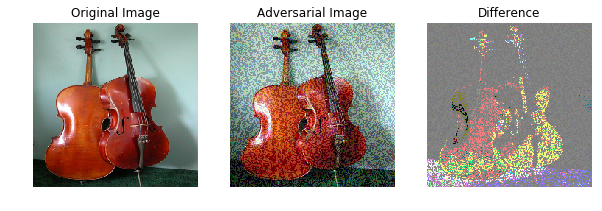

Time taken 10.77 s
Top Three original image predictions:
[('cello', 0.85292876), ('violin', 0.14698483), ('acoustic_guitar', 5.252792e-05)]
Top Three adversarial image predictions:
[('jigsaw_puzzle', 0.8414205), ('violin', 0.025683958), ('doormat', 0.011208469)]


Attacking orange image:


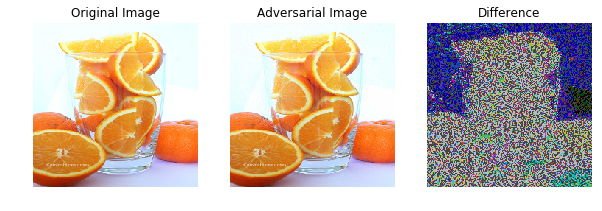

Time taken 6.91 s
Top Three original image predictions:
[('orange', 0.59407544), ('lemon', 0.37395474), ('candle', 0.026782095)]
Top Three adversarial image predictions:
[('candle', 0.9700103), ('lemon', 0.02401112), ('matchstick', 0.0023128483)]


Attacking goldfinch image:


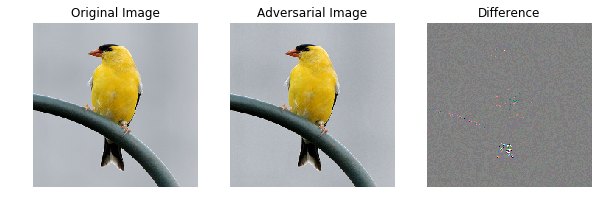

Time taken 7.85 s
Top Three original image predictions:
[('goldfinch', 0.9888172), ('bulbul', 0.00788787), ('bee_eater', 0.0015120044)]
Top Three adversarial image predictions:
[('bulbul', 0.4841112), ('bee_eater', 0.14633767), ('macaw', 0.13095364)]


Finished in 78.78 s


In [6]:
init_time=time.time()
random_index=np.random.choice(len(glob_paths),10,replace=False)
chosenimage_fname=[str(glob_paths[ind]) for ind in random_index]

for ind in range(len(chosenimage_fname)):
    start_time=time.time()
    model_image,label=load_image(chosenimage_fname[ind],model)

    criterion=TopKMisclassification(k=5)
    attack_model=KerasModel(model,bounds=(0,255))
    FGSM_attack=FGSM(attack_model,criterion=criterion)
    adversarial_image=FGSM_attack(image=model_image,label=label)
    
    difference=(model_image-adversarial_image)
    
    stop_time=time.time()
    image_name=chosenimage_fname[ind].replace('sample_images/','').replace('.jpg','')
    print("Attacking {} image:".format(image_name))
    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,10))
    ax1.set_title('Original Image')
    ax1.imshow(model_image[:,:,::-1])
    ax1.axis('off')

    ax2.set_title('Adversarial Image')
    ax2.imshow(adversarial_image[:,:,::-1]/255)
    ax2.axis('off')

    ax3.set_title('Difference')

    ax3.imshow((difference))
    ax3.axis('off')

    plt.show()
    print("Time taken {} s".format(round(stop_time-start_time,2)))
    print("Top Three original image predictions:")
    print(kpredictions(model_image,model,3))
    print("Top Three adversarial image predictions:")
    print(kpredictions(adversarial_image,model,3))
    print("\n")
end_time=time.time()
print("Finished in {} s".format(round(end_time-init_time,2)))